**IMPORT LIBRARIES**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from nltk.tokenize import RegexpTokenizer

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
credits_df = pd.read_csv('/content/credits.csv')

In [ ]:
titles_df = pd.read_csv('/content/titles.csv')

**Data Preperation and visualising data**


In [ ]:
titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934,TV-PG,19,"['comedy', 'family', 'animation', 'action', 'f...",['US'],26.0,tt0850645,8.6,1092.0,15.424,7.6
1,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926,NaN,78,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],NaN,tt0017925,8.2,89766.0,8.647,8.0
2,tm82253,The Best Years of Our Lives,MOVIE,It's the hope that sustains the spirit of ever...,1946,NaN,171,"['romance', 'war', 'drama']",['US'],NaN,tt0036868,8.1,63026.0,8.435,7.8
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,NaN,92,"['comedy', 'drama', 'romance']",['US'],NaN,tt0032599,7.8,57835.0,11.270,7.4
4,tm56584,In a Lonely Place,MOVIE,An aspiring actress begins to suspect that her...,1950,NaN,94,"['thriller', 'drama', 'romance']",['US'],NaN,tt0042593,7.9,30924.0,8.273,7.6


In [ ]:
credits_df.head()

,person_id,id,name,character,role
0,59401,ts20945,Joe Besser,Joe,ACTOR
1,31460,ts20945,Moe Howard,Moe,ACTOR
2,31461,ts20945,Larry Fine,Larry,ACTOR
3,21174,tm19248,Buster Keaton,Johnny Gray,ACTOR
4,28713,tm19248,Marion Mack,Annabelle Lee,ACTOR


In [ ]:
titles_df['title'].value_counts()

King Lear                   3
Cinderella                  3
Little Men                  3
Dynamite                    3
Mind Games                  3
                           ..
Nothing to Declare          1
Timmy Time                  1
Brigham City                1
Sex and the Teenage Mind    1
Waking Up Eighty            1
Name: title, Length: 9737, dtype: int64

In [ ]:
titles_df['title']

0                     The Three Stooges
1                           The General
2           The Best Years of Our Lives
3                       His Girl Friday
4                     In a Lonely Place
                     ...               
9866                       Lily Is Here
9867    Jay Nog: Something from Nothing
9868                            Chasing
9869                           Baikunth
9870                   Waking Up Eighty
Name: title, Length: 9871, dtype: object

In [ ]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9871 entries, 0 to 9870
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9871 non-null   object 
 1   title                 9871 non-null   object 
 2   type                  9871 non-null   object 
 3   description           9752 non-null   object 
 4   release_year          9871 non-null   int64  
 5   age_certification     3384 non-null   object 
 6   runtime               9871 non-null   int64  
 7   genres                9871 non-null   object 
 8   production_countries  9871 non-null   object 
 9   seasons               1357 non-null   float64
 10  imdb_id               9204 non-null   object 
 11  imdb_score            8850 non-null   float64
 12  imdb_votes            8840 non-null   float64
 13  tmdb_popularity       9324 non-null   float64
 14  tmdb_score            7789 non-null   float64
dtypes: float64(5), int64(

In [ ]:
# Check for any null values in the DataFrame
titles_df.isna().sum()

id                         0
title                      0
type                       0
description              119
release_year               0
age_certification       6487
runtime                    0
genres                     0
production_countries       0
seasons                 8514
imdb_id                  667
imdb_score              1021
imdb_votes              1031
tmdb_popularity          547
tmdb_score              2082
dtype: int64

In [ ]:
# Check to see if there are any duplicated movie titles
titles_df['title'].duplicated().sum()

134

In [ ]:
# Drop all of the duplicated movie titles
titles_df.drop_duplicates(subset='title', inplace=True)

In [ ]:
#check to ensure all duplicated movie titles were dropped
titles_df['title'].duplicated().sum()

0

In [ ]:
# Check the shape means rows,columns of the credits_df DataFrame
credits_df.shape

(124235, 5)

In [ ]:
# Check for any null values in the DataFrame
credits_df.isna().sum()

person_id        0
id               0
name             0
character    16287
role             0
dtype: int64

In [ ]:
credits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124235 entries, 0 to 124234
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  124235 non-null  int64 
 1   id         124235 non-null  object
 2   name       124235 non-null  object
 3   character  107948 non-null  object
 4   role       124235 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.7+ MB


**MERGE DATAFRAMES**


After taking a look at both the titles_df and credits_df it is clear that I will have to merge both of these dataframes together. I am merging on id which is the movie/show title on JustWatch. Ideally, I would like to create a recommendation system that will include and allow someone to choose a director as one of the inputs to receive recommendations based off of. Additional inputs would include being able to receive recommendations based off of genres or imdb_score.

In [ ]:
# Merge both title and credit dataframes together
movies_df = titles_df.merge(credits_df, on='id', how='outer')

In [ ]:
# Sanity check to ensure the merge was successful
movies_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934.0,TV-PG,19.0,"['comedy', 'family', 'animation', 'action', 'f...",['US'],26.0,tt0850645,8.6,1092.0,15.424,7.6,59401.0,Joe Besser,Joe,ACTOR
1,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934.0,TV-PG,19.0,"['comedy', 'family', 'animation', 'action', 'f...",['US'],26.0,tt0850645,8.6,1092.0,15.424,7.6,31460.0,Moe Howard,Moe,ACTOR
2,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934.0,TV-PG,19.0,"['comedy', 'family', 'animation', 'action', 'f...",['US'],26.0,tt0850645,8.6,1092.0,15.424,7.6,31461.0,Larry Fine,Larry,ACTOR
3,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926.0,NaN,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],NaN,tt0017925,8.2,89766.0,8.647,8.0,21174.0,Buster Keaton,Johnny Gray,ACTOR
4,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926.0,NaN,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],NaN,tt0017925,8.2,89766.0,8.647,8.0,28713.0,Marion Mack,Annabelle Lee,ACTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125224,tm1038144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962387.0,Kirbi Simon,Kirbi,ACTOR
125225,tm1038144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,795241.0,Scott Lane,Scott,ACTOR
125226,tm1038144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1026818.0,Luke Walker,NaN,DIRECTOR
125227,tm1038144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962569.0,Kandi Thompson,NaN,DIRECTOR


In [ ]:
# Take a look at all the columns after merge
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 125229 entries, 0 to 125228
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    125229 non-null  object 
 1   title                 123483 non-null  object 
 2   type                  123483 non-null  object 
 3   description           123295 non-null  object 
 4   release_year          123483 non-null  float64
 5   age_certification     55959 non-null   object 
 6   runtime               123483 non-null  float64
 7   genres                123483 non-null  object 
 8   production_countries  123483 non-null  object 
 9   seasons               8387 non-null    float64
 10  imdb_id               118345 non-null  object 
 11  imdb_score            117376 non-null  float64
 12  imdb_votes            117347 non-null  float64
 13  tmdb_popularity       122936 non-null  float64
 14  tmdb_score            112565 non-null  float64
 15  

In [ ]:
# Take a look at all the null values in the combined dataframe
movies_df.isna().sum()

id                           0
title                     1746
type                      1746
description               1934
release_year              1746
age_certification        69270
runtime                   1746
genres                    1746
production_countries      1746
seasons                 116842
imdb_id                   6884
imdb_score                7853
imdb_votes                7882
tmdb_popularity           2293
tmdb_score               12664
person_id                  994
name                       994
character                17281
role                       994
dtype: int64

Drop Irrelevant Columns As Well As Columns That Have Too Many Null Values
Since age_certification has about 70k null values, that will be the first column I drop. Next, the number of seasons has over 100k in null values which will make it difficult to compare that with any other column in the dataframe.

Since I would like to recommend title of movies, what type they are (whether it is a TV Show or Movie), the release_year of each title, runtime, genres, and imdb_score would all be either input or outputs for my recommendation system - these columns will remain in the dataframe.

However, age_certification (due to 70k null values), production_countries (because I believe this is irrelevant to my recommendation system), as well as the following columns will all be removed: description, imdb_id, imdb_votes, tmdb_popularity, tmdb_score, person_id, and character.

In [ ]:
movies_df = movies_df.drop(['description',
                            'age_certification',
                            'production_countries',
                            'seasons',
                            'imdb_id',
                            'imdb_votes',
                            'tmdb_popularity',
                            'tmdb_score',
                            'person_id',
                            'character'], axis=1)

In [ ]:
# Check dataframe to see if columns were dropped
movies_df.head()

,id,title,type,release_year,runtime,genres,imdb_score,name,role
0,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Joe Besser,ACTOR
1,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Moe Howard,ACTOR
2,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Larry Fine,ACTOR
3,tm19248,The General,MOVIE,1926.0,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",8.2,Buster Keaton,ACTOR
4,tm19248,The General,MOVIE,1926.0,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",8.2,Marion Mack,ACTOR


In [ ]:
# Check the columns and feature types
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125229 entries, 0 to 125228
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            125229 non-null  object 
 1   title         123483 non-null  object 
 2   type          123483 non-null  object 
 3   release_year  123483 non-null  float64
 4   runtime       123483 non-null  float64
 5   genres        123483 non-null  object 
 6   imdb_score    117376 non-null  float64
 7   name          124235 non-null  object 
 8   role          124235 non-null  object 
dtypes: float64(3), object(6)
memory usage: 9.6+ MB


In [ ]:
movies_df.isna().sum()

id                 0
title           1746
type            1746
release_year    1746
runtime         1746
genres          1746
imdb_score      7853
name             994
role             994
dtype: int64

Drop Null Values
Since title, type, release_year, runtime, genres only have 1,746 null values and name and role with 994 null values - I am going to drop those values from the dataset.

However, imdb_score has a higher null value count with 7,853 - I will have to apply an imputer of some kind to deal with these null values. I am most likely going to apply a KNN imputer to fill the null values with a more representative value. In addition, I will keep the null values in the description column because I am going to use NLP (Natural Language Processing) to parse through all the words.

In [ ]:
movies_df = movies_df.dropna(axis=0, subset=['title','type','release_year','runtime','genres','name','role'])

In [ ]:
# Check to ensure nulls are dropped from the correct columns, imdb_score should remain intact
movies_df.isna().sum()

id                 0
title              0
type               0
release_year       0
runtime            0
genres             0
imdb_score      5795
name               0
role               0
dtype: int64

In [ ]:
# Checking the shape of my dataframe
movies_df.shape

(122489, 9)

In [ ]:
# Check dataframe for duplicates
movies_df.duplicated().sum()

252

In [ ]:
# Take a look at which items are duplicated
movies_df[movies_df.duplicated()]

,id,title,type,release_year,runtime,genres,imdb_score,name,role
1705,tm77319,Santa Fe Trail,MOVIE,1940.0,110.0,"['western', 'war', 'drama', 'history', 'romance']",6.2,Jack Deery,ACTOR
1872,tm4525,He Walked by Night,MOVIE,1949.0,79.0,"['thriller', 'crime']",7.1,Thomas Browne Henry,ACTOR
4424,tm73200,Li'l Abner,MOVIE,1940.0,78.0,"['comedy', 'romance']",4.9,Buster Keaton,ACTOR
6049,tm85300,Outlaws of the Desert,MOVIE,1941.0,66.0,"['western', 'action']",5.8,Bill Nestell,ACTOR
6220,tm54261,Indiscreet,MOVIE,1931.0,92.0,"['drama', 'romance', 'comedy']",6.2,Sam Lufkin,ACTOR
...,...,...,...,...,...,...,...,...,...
121107,tm1103576,Bhramam,MOVIE,2021.0,152.0,"['thriller', 'crime']",5.7,Shine Tom Chacko,ACTOR
121672,tm1043367,Open Your Eyes,MOVIE,2021.0,99.0,"['horror', 'thriller', 'drama']",4.2,Suzy Giannakopoulos,ACTOR
121742,tm1104220,My Best Worst Adventure,MOVIE,2021.0,85.0,[],7.8,Claudia Templeton,ACTOR
122740,tm1040662,Eternity,MOVIE,2021.0,45.0,['drama'],NaN,Crystal Jones,ACTOR


In [ ]:
# Checking one unique value to determine if there are actual duplicates
movies_df[(movies_df['id'] == 'tm54261') & (movies_df['name'] == 'Sam Lufkin') ]

,id,title,type,release_year,runtime,genres,imdb_score,name,role
6219,tm54261,Indiscreet,MOVIE,1931.0,92.0,"['drama', 'romance', 'comedy']",6.2,Sam Lufkin,ACTOR
6220,tm54261,Indiscreet,MOVIE,1931.0,92.0,"['drama', 'romance', 'comedy']",6.2,Sam Lufkin,ACTOR


**I wanted to double check this because some movies may have multiple actors within the role column for the same title of movie. It appears that the 252 duplicates are actually dupicated values, therefore, I will be dropping all 252 duplicates.**

In [ ]:
# Dropping all of the duplicated values
movies_df = movies_df.drop_duplicates()

In [ ]:
# Checking to ensure all duplicated items have been removed
movies_df.duplicated().sum()

0

In [ ]:
# Rechecking the shape of my dataframe
movies_df.shape

(122237, 9)

Reformat genres Column
I chose to reformat the genres column so that it would be easier for a user to select genres when looking for recommendations.

In [ ]:
# Take a look at movies_df to determine which characters I want to remove from genres column
movies_df.head()

,id,title,type,release_year,runtime,genres,imdb_score,name,role
0,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Joe Besser,ACTOR
1,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Moe Howard,ACTOR
2,ts20945,The Three Stooges,SHOW,1934.0,19.0,"['comedy', 'family', 'animation', 'action', 'f...",8.6,Larry Fine,ACTOR
3,tm19248,The General,MOVIE,1926.0,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",8.2,Buster Keaton,ACTOR
4,tm19248,The General,MOVIE,1926.0,78.0,"['action', 'drama', 'war', 'western', 'comedy'...",8.2,Marion Mack,ACTOR


I used the .replace method and chained them together in one list comprehension to remove all of the unnecessary characters from the genres column. (Having one list comprehension makes for easier readability)

In [ ]:
movies_df['genres'] = [row.strip().replace('[','').replace("'",'').replace(']','') for row in movies_df['genres']]

In [ ]:
# Sanity check to ensure the unwanted characters were removed
movies_df.head()

,id,title,type,release_year,runtime,genres,imdb_score,name,role
0,ts20945,The Three Stooges,SHOW,1934.0,19.0,"comedy, family, animation, action, fantasy, ho...",8.6,Joe Besser,ACTOR
1,ts20945,The Three Stooges,SHOW,1934.0,19.0,"comedy, family, animation, action, fantasy, ho...",8.6,Moe Howard,ACTOR
2,ts20945,The Three Stooges,SHOW,1934.0,19.0,"comedy, family, animation, action, fantasy, ho...",8.6,Larry Fine,ACTOR
3,tm19248,The General,MOVIE,1926.0,78.0,"action, drama, war, western, comedy, european",8.2,Buster Keaton,ACTOR
4,tm19248,The General,MOVIE,1926.0,78.0,"action, drama, war, western, comedy, european",8.2,Marion Mack,ACTOR


**Since I am creating a content-based filtering recommendation system, I have created a dataframe which will represent the important characteristics of each movie. Since each movie will represent an item in a profile, then its actors, director, release year, runtime, genre, along with the IMDB score represent the significant features of that movie.

Separate genres Column
In this section, I took the genres column and split each genre into its own individual/separate column. Each new column of genres will include an assignment of either 1 or 0, where 1 will indicate that this genre is included in this particular movie title or 0 indicating that the genre is not included in this movie title.**

In [ ]:
# Use tokenizer to split each genre name into an individual string
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
movies_df['genres'] = [tokenizer.tokenize(token) for token in movies_df['genres']]

In [ ]:
# Create flat_list
flat_list = [item for sublist in movies_df['genres'] for item in sublist]

In [ ]:
# Set that flat_list to be a list
flat_list = list(set(flat_list))
flat_list

['comedy',
 'fantasy',
 'drama',
 'sport',
 'romance',
 'european',
 'documentation',
 'family',
 'crime',
 'horror',
 'history',
 'animation',
 'music',
 'thriller',
 'reality',
 'action',
 'scifi',
 'war',
 'western']

In [ ]:
# Creating for loop to loop over each genre, creating separate column for each genre, and assigning True or False
for genre in flat_list:
    movies_df[genre]=[1 if genre in movie else 0 for movie in movies_df['genres']]

In [ ]:
# Sanity check to ensure the for loop worked
movies_df.head()

,id,title,type,release_year,runtime,genres,imdb_score,name,role,comedy,...,horror,history,animation,music,thriller,reality,action,scifi,war,western
0,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Joe Besser,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
1,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Moe Howard,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
2,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Larry Fine,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
3,tm19248,The General,MOVIE,1926.0,78.0,"[action, drama, war, western, comedy, european]",8.2,Buster Keaton,ACTOR,1,...,0,0,0,0,0,0,1,0,1,1
4,tm19248,The General,MOVIE,1926.0,78.0,"[action, drama, war, western, comedy, european]",8.2,Marion Mack,ACTOR,1,...,0,0,0,0,0,0,1,0,1,1


In [ ]:
movies_df['genres'].astype('string')

0         ['comedy', 'family', 'animation', 'action', 'f...
1         ['comedy', 'family', 'animation', 'action', 'f...
2         ['comedy', 'family', 'animation', 'action', 'f...
3         ['action', 'drama', 'war', 'western', 'comedy'...
4         ['action', 'drama', 'war', 'western', 'comedy'...
                                ...                        
123477                                  ['family', 'drama']
123478                                  ['family', 'drama']
123479                                  ['family', 'drama']
123480                                  ['family', 'drama']
123481                                  ['family', 'drama']
Name: genres, Length: 122237, dtype: string

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122237 entries, 0 to 123481
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             122237 non-null  object 
 1   title          122237 non-null  object 
 2   type           122237 non-null  object 
 3   release_year   122237 non-null  float64
 4   runtime        122237 non-null  float64
 5   genres         122237 non-null  object 
 6   imdb_score     116446 non-null  float64
 7   name           122237 non-null  object 
 8   role           122237 non-null  object 
 9   comedy         122237 non-null  int64  
 10  fantasy        122237 non-null  int64  
 11  drama          122237 non-null  int64  
 12  sport          122237 non-null  int64  
 13  romance        122237 non-null  int64  
 14  european       122237 non-null  int64  
 15  documentation  122237 non-null  int64  
 16  family         122237 non-null  int64  
 17  crime          122237 non-nul

In [ ]:
movies_df.head()

,id,title,type,release_year,runtime,genres,imdb_score,name,role,comedy,...,horror,history,animation,music,thriller,reality,action,scifi,war,western
0,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Joe Besser,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
1,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Moe Howard,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
2,ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,Larry Fine,ACTOR,1,...,1,0,1,0,0,0,1,0,0,0
3,tm19248,The General,MOVIE,1926.0,78.0,"[action, drama, war, western, comedy, european]",8.2,Buster Keaton,ACTOR,1,...,0,0,0,0,0,0,1,0,1,1
4,tm19248,The General,MOVIE,1926.0,78.0,"[action, drama, war, western, comedy, european]",8.2,Marion Mack,ACTOR,1,...,0,0,0,0,0,0,1,0,1,1


Combine Names Into One Column
In this section, I took the actor/director names in the name column and combined them to be viewable in one row based on each movie title. First, I created a cast_list_series function that grouped each actor/director name together based on each movie title. Second, I dropped all duplicated values from my entire movie_df based on each unique movie id. Third, I created the below for loop to loop over each movie title and name, replacing each name in the name column with my cast_list_series names.

In [ ]:
# Create a function for cast_list_series that groups names individually by movie title
cast_list_series = movies_df.groupby('title')['name'].apply(','.join)

In [ ]:
# Drop movie title duplicates by unique id
movies_df.drop_duplicates(subset='id', inplace=True)

In [ ]:
# Create for loop to reassign cast_list_series to name column in movies_df
for movie_title in movies_df.title.unique():
    movies_df.loc[movies_df.title == movie_title, ['name']] = cast_list_series[movie_title]

In [ ]:
# Check last 10 rows to ensure all changes took affect
movies_df.tail(30)

,id,title,type,release_year,runtime,genres,imdb_score,name,role,comedy,...,horror,history,animation,music,thriller,reality,action,scifi,war,western
123252,tm1019089,MAX: Live from the Greek Theatre,MOVIE,2021.0,42.0,[music],NaN,Max Schneider,ACTOR,0,...,0,0,0,1,0,0,0,0,0,0
123257,tm1072724,Trip to the Tax Paradise - Rumbo al Paraíso Fi...,MOVIE,2021.0,74.0,[music],NaN,"Antonio Bellido Marin,Oscar Carreras,Luisa Gil...",ACTOR,0,...,0,0,0,1,0,0,0,0,0,0
123268,tm996725,Kabadadaari,MOVIE,2021.0,146.0,"[crime, thriller, drama]",6.5,"Sibiraj,Nandita Swetha,Nassar,Jayaprakash,Suma...",ACTOR,0,...,0,0,0,0,1,0,0,0,0,0
123280,tm901122,The Bid,MOVIE,2021.0,90.0,[comedy],4.1,"Richard Harris,Maurquis Boone,Hakim Clark,Nafe...",ACTOR,1,...,0,0,0,0,0,0,0,0,0,0
123286,tm534294,Hal King,MOVIE,2021.0,114.0,"[drama, war]",6.3,"Kareem Ghaleb,J. Ivy,Sophia Stephens,Tarrey To...",ACTOR,0,...,0,0,0,0,0,0,0,0,1,0
123292,ts302433,Aham Bhramhasmi,SHOW,2021.0,25.0,[],NaN,"Chandni Rao,Abhay Bethiganti,Krishna Teja,Mounima",ACTOR,0,...,0,0,0,0,0,0,0,0,0,0
123297,tm1074422,27 September,MOVIE,2021.0,81.0,[drama],7.7,"Meenakshi Rai,Vinay Rai,Meenakshi Vinay Rai",ACTOR,0,...,0,0,0,0,0,0,0,0,0,0
123300,tm952811,Attraction to Paris,MOVIE,2021.0,112.0,"[action, crime, thriller]",3.5,"Christopher Atkins,Tara Reid,Dina De Laurentii...",ACTOR,0,...,0,0,0,0,1,0,1,0,0,0
123307,tm1062990,Chloe's Mountain,MOVIE,2021.0,107.0,"[family, drama]",4.1,"Kenzie Mae,Shalayna Janelle,Lynne Yeaman,Donna...",ACTOR,0,...,0,0,0,0,0,0,0,0,0,0
123317,tm515444,No Witnesses,MOVIE,2021.0,101.0,"[crime, thriller]",3.1,"Jacob Machin,Annie Wilson,Taya Calder-Mason,Ed...",ACTOR,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Recheck the shape of the entire dataframe
movies_df.shape

(8743, 28)

In [ ]:
# Set the index of movies_df to the movie id
movies_df.set_index('id', inplace=True)

**Data Preprocessing
Please Note:
A train_test_split was not performed due to recommendation systems being unsupervised training models.
Before I begin my data preprocessing I am going to create a copy of my final dataframe, model_df, to be used for modeling purposes while ensuring the main dataframe isn't being touched during the modeling process. Also, I will be dropping the id, genres, title, type, release_year, runtime, name, role columns since I will not need any of this information to run my Cosine Similarity Model**

In [ ]:
# Create a copy of the final dataframe
model_df = movies_df.copy()

In [ ]:

# Drop unneeded columns
model_df = model_df.drop(columns=['genres','title', 'type', 'release_year','runtime','name','role'])

In [ ]:
# Create meta_df
meta_df = movies_df.copy()

In [ ]:
# Check the top 5 rows of meta_df
meta_df.head()

,title,type,release_year,runtime,genres,imdb_score,name,role,comedy,fantasy,...,horror,history,animation,music,thriller,reality,action,scifi,war,western
id,,,,,,,,,,,,,,,,,,,,,
ts20945,The Three Stooges,SHOW,1934.0,19.0,"[comedy, family, animation, action, fantasy, h...",8.6,"Joe Besser,Moe Howard,Larry Fine",ACTOR,1,1,...,1,0,1,0,0,0,1,0,0,0
tm19248,The General,MOVIE,1926.0,78.0,"[action, drama, war, western, comedy, european]",8.2,"Buster Keaton,Marion Mack,Glen Cavender,Jim Fa...",ACTOR,1,0,...,0,0,0,0,0,0,1,0,1,1
tm82253,The Best Years of Our Lives,MOVIE,1946.0,171.0,"[romance, war, drama]",8.1,"Myrna Loy,Fredric March,Dana Andrews,Teresa Wr...",ACTOR,0,0,...,0,0,0,0,0,0,0,0,1,0
tm83884,His Girl Friday,MOVIE,1940.0,92.0,"[comedy, drama, romance]",7.8,"Cary Grant,Rosalind Russell,Ralph Bellamy,Gene...",ACTOR,1,0,...,0,0,0,0,0,0,0,0,0,0
tm56584,In a Lonely Place,MOVIE,1950.0,94.0,"[thriller, drama, romance]",7.9,"Humphrey Bogart,Gloria Grahame,Frank Lovejoy,C...",ACTOR,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Take a look at all columns in meta_df
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8743 entries, ts20945 to tm1054116
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          8743 non-null   object 
 1   type           8743 non-null   object 
 2   release_year   8743 non-null   float64
 3   runtime        8743 non-null   float64
 4   genres         8743 non-null   object 
 5   imdb_score     8055 non-null   float64
 6   name           8743 non-null   object 
 7   role           8743 non-null   object 
 8   comedy         8743 non-null   int64  
 9   fantasy        8743 non-null   int64  
 10  drama          8743 non-null   int64  
 11  sport          8743 non-null   int64  
 12  romance        8743 non-null   int64  
 13  european       8743 non-null   int64  
 14  documentation  8743 non-null   int64  
 15  family         8743 non-null   int64  
 16  crime          8743 non-null   int64  
 17  horror         8743 non-null   int64  
 18  hi

In [ ]:
#Describe final_movies_df
#The descriptive statistics are important to know what the mean values are for each movie feature. This could be used to filter out movies that don't meet certain thresholds.

# Take a look at descriptive statistics
model_df.describe()

,imdb_score,comedy,fantasy,drama,sport,romance,european,documentation,family,crime,horror,history,animation,music,thriller,reality,action,scifi,war,western
count,8055.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000
mean,5.933656,0.315910,0.059705,0.499142,0.023219,0.190552,0.078120,0.101109,0.073659,0.135423,0.114949,0.040375,0.042091,0.046437,0.230013,0.010980,0.197415,0.074803,0.035343,0.054672
std,1.318993,0.464904,0.236953,0.500028,0.150606,0.392759,0.268375,0.301491,0.261230,0.342194,0.318979,0.196849,0.200808,0.210442,0.420865,0.104216,0.398071,0.263088,0.184655,0.227353
min,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.900000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Impute The imdb_score Null Values
Due to univariate methods (such as SimpleImpute) used for imputing missing values is a very simple way of estimating values (using mean, median, most-frequent), I do not feel this method is appropriate for answering my overall business problem. For this reason, I have decided to use the KNNImputer since it helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.

KNNImputer documentation found here
Further explanation found here
First, I have created a new dataframe named imdb_df to filter into the imdb_score because the KNNImputer can only impute on a 2 dimensional array.

In [ ]:
# Create a new dataframe filtering into imdb_score column
imdb_df = model_df.filter(['imdb_score'])
imdb_df

,imdb_score
id,
ts20945,8.6
tm19248,8.2
tm82253,8.1
tm83884,7.8
tm56584,7.9
...,...
tm822572,4.0
tm510327,5.3
tm1079144,NaN


In [ ]:
# Instantiate KNNImputer
imputer = KNNImputer()

In [ ]:
# Fit Transform KNNImputer on Training Set
imdb_imputed = imputer.fit_transform(imdb_df)

In [ ]:
# Reassign final dataframe with imputed column
model_df['imdb_score'] = imdb_imputed

In [ ]:
# Sanity check to ensure all of the nulls have been imputed
model_df.imdb_score.isna().sum()

0

In [ ]:
# Reassign meta_df with imputed scores
meta_df['imdb_score'] = imdb_imputed

# Save meta_df as a CSV - to be used in Streamlit
meta_df.to_csv('meta_df.csv', index=False)

Scale Data Using MinMaxScaler
Since most of the numbers in the imdb_score column are in different units, I am going to normalize the data using the MinMaxScaler so that everything is on the same scale. By scaling all of the data, I can ensure my model will be able to learn more efficiently and weigh the different attributes similarly.

In addition, I chose to use MinMaxScaler over StandardScaler because the latter does not guarantee balanced feature scales while the MinMaxScaler scales all the data features in a range of 0 and 1.

In [ ]:
# Instantiate MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Create a cols variable with the imdb_score column
cols = ['imdb_score']
# Fit and transform on training data
scaled = scaler.fit_transform(model_df[cols])

In [ ]:
# Create new dataframe using scaled data
scaled_column_df = pd.DataFrame(data=scaled, index=model_df.index)

In [ ]:
# Add the scaled imdb_score column back into the main DataFrame
model_df['imdb_score'] = scaled_column_df

# Save model_df as a CSV - to be used in Streamlit

model_df.to_csv('model_df.csv', index=False)

In [ ]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8743 entries, ts20945 to tm1054116
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   imdb_score     8743 non-null   float64
 1   comedy         8743 non-null   int64  
 2   fantasy        8743 non-null   int64  
 3   drama          8743 non-null   int64  
 4   sport          8743 non-null   int64  
 5   romance        8743 non-null   int64  
 6   european       8743 non-null   int64  
 7   documentation  8743 non-null   int64  
 8   family         8743 non-null   int64  
 9   crime          8743 non-null   int64  
 10  horror         8743 non-null   int64  
 11  history        8743 non-null   int64  
 12  animation      8743 non-null   int64  
 13  music          8743 non-null   int64  
 14  thriller       8743 non-null   int64  
 15  reality        8743 non-null   int64  
 16  action         8743 non-null   int64  
 17  scifi          8743 non-null   int64  
 18  wa


Recommender Function & Models
I have created a function that takes in a user-inputted movie title and a number of recommendations (n_numbers) and it returns the top movie recommendations. As expected, a content-based system returns recommendations that follow closely along genre lines. The movie title input is used to index the DataFrame based on the JustWatch movie_id (ID). All of the results that are returned are sorted in descending order based on each movie title score. The meta_df DataFrame is used to index into the inputted movie title and return all of the information pertaining to the top recommendations

Cosine Similarity
I am going to create a Cosine Similarity Matrix using my model_df that doesn't include the columns that are not needed for this particular model. Then I am assigning this to a new DataFrame named cosine_df just to take a look at the similarity matrix.

In [ ]:
cosine = cosine_similarity(model_df)
cosine_df = pd.DataFrame(data=cosine, index=model_df.index)
cosine_df

,0,1,2,3,4,5,6,7,8,9,...,8733,8734,8735,8736,8737,8738,8739,8740,8741,8742
id,,,,,,,,,,,,,,,,,,,,,
ts20945,1.000000,0.401825,0.137147,0.336031,0.133887,0.155775,0.600421,0.123819,0.338323,0.074577,...,0.328616,0.496157,0.158207,0.209809,0.338126,0.102853,0.141544,0.496157,0.158207,0.401436
tm19248,0.401825,1.000000,0.537450,0.535783,0.331910,0.631143,0.435499,0.325249,0.536913,0.338029,...,0.312848,0.490477,0.490477,0.498179,0.603666,0.466191,0.484695,0.490477,0.150616,0.394788
tm82253,0.137147,0.537450,1.000000,0.722559,0.723307,0.524500,0.587143,0.437843,0.724029,0.456029,...,0.417347,0.200925,0.660785,0.670271,0.453555,0.628929,0.653264,0.200925,0.200925,0.531164
tm83884,0.336031,0.535783,0.722559,1.000000,0.721308,0.519832,0.805934,0.434287,0.999940,0.455308,...,0.402411,0.656991,0.656991,0.663717,0.817570,0.627935,0.650328,0.656991,0.193734,0.525971
tm56584,0.133887,0.331910,0.723307,0.721308,1.000000,0.521411,0.585777,0.717468,0.722665,0.455563,...,0.407427,0.196149,0.658281,0.665932,0.453166,0.628287,0.651331,0.196149,0.196149,0.527726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tm822572,0.102853,0.466191,0.628929,0.627935,0.628287,0.739697,0.508365,0.625860,0.628618,0.725087,...,0.312988,0.150683,0.983128,0.930815,0.723903,1.000000,0.991951,0.150683,0.150683,0.737635
tm510327,0.141544,0.484695,0.653264,0.650328,0.651331,0.766076,0.530543,0.644940,0.652310,0.719251,...,0.430730,0.207368,0.998377,0.969602,0.717133,0.991951,1.000000,0.207368,0.207368,0.768373
tm1079144,0.496157,0.490477,0.200925,0.656991,0.196149,0.228216,0.537737,0.181399,0.659546,0.109258,...,0.481434,1.000000,0.231778,0.307377,0.710327,0.150683,0.207368,1.000000,0.231778,0.243585


Building Recommender Function
In this section, I going to begin building my recommendation system which will then be placed/combined into one function that will include all of these steps to provide a specified number of recommendations to the user.

In [ ]:
# Input for movie title that returns the 'movie_title' index number for the movie to be used to call dataframe
title = input('Title: ')
movie1 = meta_df.index[meta_df['title'] == title]
movie1

Title: Roommate


Index(['tm1065569'], dtype='object', name='id')

In [ ]:
# Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
cos_sim = cosine_similarity(model_df)

# Create a dataframe with similairty scores with movie JustWatch ID ('id') as index
cos_sim = pd.DataFrame(data=cos_sim, index=model_df.index)
cos_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,8733,8734,8735,8736,8737,8738,8739,8740,8741,8742
id,,,,,,,,,,,,,,,,,,,,,
ts20945,1.000000,0.401825,0.137147,0.336031,0.133887,0.155775,0.600421,0.123819,0.338323,0.074577,...,0.328616,0.496157,0.158207,0.209809,0.338126,0.102853,0.141544,0.496157,0.158207,0.401436
tm19248,0.401825,1.000000,0.537450,0.535783,0.331910,0.631143,0.435499,0.325249,0.536913,0.338029,...,0.312848,0.490477,0.490477,0.498179,0.603666,0.466191,0.484695,0.490477,0.150616,0.394788
tm82253,0.137147,0.537450,1.000000,0.722559,0.723307,0.524500,0.587143,0.437843,0.724029,0.456029,...,0.417347,0.200925,0.660785,0.670271,0.453555,0.628929,0.653264,0.200925,0.200925,0.531164
tm83884,0.336031,0.535783,0.722559,1.000000,0.721308,0.519832,0.805934,0.434287,0.999940,0.455308,...,0.402411,0.656991,0.656991,0.663717,0.817570,0.627935,0.650328,0.656991,0.193734,0.525971
tm56584,0.133887,0.331910,0.723307,0.721308,1.000000,0.521411,0.585777,0.717468,0.722665,0.455563,...,0.407427,0.196149,0.658281,0.665932,0.453166,0.628287,0.651331,0.196149,0.196149,0.527726


In [ ]:
#Cossine similarity recommender function
# Input used to ask how many recommendations the user would like returned
n_recs = int(input('How many recommendations? '))

# The cos_sim scores then need to be sorted in descending order
cos_sim.sort_values(by=0, ascending=False, inplace=True)

# In order to not return the original movie input first, you need to obtain the index values for the requested number of recommendations
indices = cos_sim.index.values[1:n_recs + 1]

# Get the movie names associated with the indices
results = [meta_df.loc[index, 'title'] for index in indices]

# Print the recommended movie names
print(f'Top {n_recs} recommended movies:')
for result in results:
    print(result)


How many recommendations? 5
Top 5 recommended movies:
Regal Academy
Combat Wombat
Dora the Explorer
Pokémon
Gulliver's Travels


In [ ]:
# Compiling the above code into a working function that takes a movie title as input and returns n-recommendations
def cos_movie_recommend():

    title = input('Title: ')
    movie2 = meta_df.index[meta_df['title'] == title]
    n_recs = int(input('How many recommendations? '))
    m_or_s = input('Would you like MOVIE or SHOW recommendations? ')

    y = np.array(model_df.loc[movie2]).reshape(1, -1)
    cos_sim = cosine_similarity(model_df, y)
    cos_sim = pd.DataFrame(data=cos_sim, index=model_df.index)
    cos_sim.sort_values(by = 0, ascending = False, inplace=True)
    results = cos_sim.index.values[1:n_recs+5]
    results_df = meta_df.loc[results]
    results_df.reset_index(inplace=True)

    # Rename and capitalize columns
    results_df.rename(columns={'title':'Movie Title',
                              'type':'Type',
                              'release_year':'Release Year',
                              'runtime':'Runtime (minutes)',
                              'genres':'Genres',
                              'imdb_score':'IMDB Score',
                              'name':'Cast Name'}, inplace=True)

    # Filter on the type (movie or show)
    results_df  = results_df[results_df['Type'] == m_or_s]

    # Convert Release Year and Runtime columns to display as an integer instead of a float
    results_df[['Release Year','Runtime (minutes)']] = results_df[['Release Year','Runtime (minutes)']].astype(int)


    # Only display relevant columns
    return results_df.filter(['Movie Title','Type','Release Year','Runtime (minutes)','Genres','IMDB Score','Cast Name']).head

K-Nearest Neighbors (KNN)
KNN appears to yield strong recommendations across multiple genres. The final results do not appear to be showing similar results as the Cosine Similarity recommender system which suggests that both of these systems are working properly.

The following hyperparameter values were tested:

metric

manhattan
minkowski
euclidean
chebyshev
algorithm

brute
ball_tree
kd_tree
auto
n_neighbors

3
5
7
9
11
Please Note:
Metric= 'manhattan', algorithm= 'brute', n_neighbors= 7 demonstrated to yield a wider variety of results compared to Cosine Similarity. Other hyperparameter combinations did not add any value by showing almost identical results.

In [ ]:
# Instaniate and fit the model using merged dataframe
knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)
knn.fit(model_df)

# Return results using .kneighbors attribute of knn model
results2 = knn.kneighbors(n_neighbors=n_recs+1, return_distance=False).flatten()
results2 = model_df.iloc[results2].index.values[1:]
results2

array(['tm933725', 'ts13984', 'ts84637', ..., 'tm1086831', 'tm519084',
       'tm21231'], dtype=object)

In [ ]:
# Compiling the above code into a working function that takes a movie title as input and returns n-recommendations
def knn_movie_recommend():

    title = input('Title: ')
    movie3 = meta_df.index[meta_df['title'] == title]
    n_recs = int(input('How many recommendations? '))
    m_or_s = input('Would you like MOVIE or SHOW recommendations? ')

    X = np.array(model_df.loc[movie3]).reshape(1, -1)
    results2 = knn.kneighbors(X, n_neighbors=n_recs+50, return_distance=False).flatten()
    results2 = model_df.iloc[results2].index.values[1:]
    results2
    results_df = meta_df.loc[results2]
    results_df.reset_index(inplace=True)

    # Rename and capitalize columns
    results_df.rename(columns={'title':'Movie Title',
                              'type':'Type',
                              'release_year':'Release Year',
                              'runtime':'Runtime (mins)',
                              'genres':'Genres',
                              'imdb_score':'IMDB Score',
                              'name':'Cast Name'}, inplace=True)

    # Filter on the type (movie or show)
    results_df  = results_df[results_df['Type'] == m_or_s]

    # Convert Release Year and Runtime columns to display as an integer instead of a float
    results_df[['Release Year','Runtime (mins)']] = results_df[['Release Year','Runtime (mins)']].astype(int)

    # Only display relevant columns
    return results_df.filter(['Movie Title','Type','Release Year','Runtime (mins)','Genres','IMDB Score','Cast Name']).head(n_recs)

In [ ]:
knn_movie_recommend()

Title: Mahanati
How many recommendations? 6
Would you like MOVIE or SHOW recommendations? MOVIE


,Movie Title,Type,Release Year,Runtime (mins),Genres,IMDB Score,Cast Name
0,Life Ain't Like the Movies,MOVIE,2021,85,[drama],8.6,"Cynda Williams,Paul Bates,Wendell Kinney,Grace..."
1,Mahanati,MOVIE,2018,176,[drama],8.6,"Keerthy Suresh,Dulquer Salmaan,Samantha Ruth P..."
2,Runanubandha - The He Without Him,MOVIE,2018,110,[drama],8.5,"Priyanka Ghosh Roy,Amartya Bhattacharyya,Swast..."
3,Aruvi,MOVIE,2017,122,[drama],8.5,"Aditi Balan,Shwetha Shekar,Lakshmi Gopalaswamy..."
4,The Pearl,MOVIE,2001,115,[drama],8.5,"Richard Harris,Lukas Haas,Tere López Tarin,Alf..."
5,Kartha,MOVIE,2021,155,[drama],8.7,Deepthi Manne


In [ ]:
knn_movie_recommend()

Title: The General
How many recommendations? 5
Would you like MOVIE or SHOW recommendations? MOVIE


,Movie Title,Type,Release Year,Runtime (mins),Genres,IMDB Score,Cast Name
0,All Hat,MOVIE,2007,89,"[action, comedy, drama, western, european]",5.1,"Rachael Leigh Cook,Luke Kirby,Keith Carradine,..."
1,Vendetta,MOVIE,1971,92,"[western, comedy, drama, action, european]",4.6,"Telly Savalas,Clint Walker,José María Prada,Án..."
3,A Fistful of Dynamite,MOVIE,1971,157,"[western, european, drama, war]",7.6,"Rod Steiger,James Coburn,Romolo Valli,Maria Mo..."
4,Let the Bullets Fly,MOVIE,2010,132,"[comedy, drama, western, action]",7.2,"Chow Yun-Fat,Ge You,Jiang Wen,Carina Lau,Chen ..."
5,Kabullywood,MOVIE,2017,84,"[drama, comedy, war, european]",7.2,"Mohd Qais Shaghasy,Farid Joya,Roya Heydari,Ghu..."


Conclusions
Both of the recommendation systems appear to be performing quite well. They are both able to provide a variety of recommendations that use the genre of a movie/show title as a basis of providing these recommendations. I leveraged two models used particularly for a content based filtering recommendation system that included: Cosine Similarity and K-Nearnest Neighbors. It only makes sense that both of these models provide either identical or very similar results based on the way the algorithms score each movie based on its genre(s). Given the number of results within the scope of the provided movie or show title, there is a strong relationship with the similarity and recommendations that are provided to that user.

Limitations
There are a few limitations with this project that include:

The data relies heavily on the original movie id that is available on JustWatch to provide its recommendations. If a movie id was not available for a particular title, that movie would go unseen when calculating similarity scores, thus not providing a holistic recommendation.

Amazon Prime Video is still in the early phases of obtaining licenses and purchasing new content for their streaming service. Therefore, having about 9,000 total movie and show titles is a very small number of titles to represent a strong recommendation system. Having a much larger number of movie shows and titles would help to significantly improve their recommendation system.

Amazon likes to keep all of their data proprietary, therefore making it very difficult for data scientists such as myself to retrieve information regarding any of their services including Amazon Prime Video. There are currently no developer API's for Amazon Prime, forcing people to only use publically available datasets.

Next Steps
Expanding the data by finding additional Amazon Prime Video datasets that are available to the public.

Potentially using web scraping to gather additional data.

Include movie/show descriptions and implement NLP for the user to be able to filter based on words.

Deploying the final model function to a mobile app, or at least making it available on a website for people to use.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer

# ... (Your existing code for data preparation)

# Split the data into features and target
X = model_df.drop(columns=['imdb_score'])
y = model_df['imdb_score']

# Define the number of folds
n_splits = 5  # You can adjust this based on your preference

# Initialize K-Fold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize KNN model
knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)

# Initialize imputer
imputer = KNNImputer()

# Initialize scaler
scaler = MinMaxScaler()

# Initialize empty lists to store results
cosine_rmse_list = []
knn_rmse_list = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values using KNNImputer
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Fit KNN model
    knn.fit(X_train_scaled)

    # Use KNN model to get recommendations
    _, results_knn_indices = knn.kneighbors(X_test_scaled, n_neighbors=10, return_distance=True)
    results_knn = y.iloc[results_knn_indices.flatten()].mean()  # Retrieve mean IMDb scores using indices

    # Get actual IMDb scores for testing set
    y_test_actual = y_test.values

    # Calculate RMSE for KNN
    knn_rmse = np.sqrt(np.mean((y_test_actual - results_knn)**2))
    knn_rmse_list.append(knn_rmse)

    # Cosine Similarity
    cos_sim_matrix = cosine_similarity(X_test_scaled)
    results_cosine = pd.DataFrame(data=cos_sim_matrix, index=X_test.index)
    results_cosine['predicted'] = results_cosine.idxmax(axis=1)

    # Get actual IMDb scores for testing set
    y_test_actual = y_test.values

    # Calculate RMSE for Cosine Similarity
    cosine_rmse = np.sqrt(np.mean((y_test_actual - results_cosine['predicted'])**2))
    cosine_rmse_list.append(cosine_rmse)

print("Average RMSE for KNN:", np.mean(knn_rmse_list))


Average RMSE for KNN: 0.1443265834980849


In [ ]:
# Print actual and predicted IMDb scores for a few instances
comparison_df = pd.DataFrame({'Actual': y_test_actual, 'Predicted_Cosine': results_cosine['predicted']})
print(comparison_df.head(10))


            Actual  Predicted_Cosine
id                                  
tm82253   0.795455                 0
tm83884   0.761364                 1
tm56584   0.772727                 2
tm160494  0.761364                 3
tm112005  0.329545                 4
tm22806   0.750000                 5
tm89268   0.659091                 6
tm79732   0.636364                 7
tm71517   0.704545                 8
tm140761  0.670455                 9


In [ ]:
# Cosine Similarity
cos_sim_matrix = cosine_similarity(X_test_scaled)
results_cosine = pd.DataFrame(data=cos_sim_matrix, index=X_test.index)

# Get indices of most similar instances
most_similar_indices = results_cosine.apply(lambda row: row.argsort()[-10:][::-1], axis=1)

# Retrieve mean IMDb scores using indices
results_cosine['predicted'] = most_similar_indices.apply(lambda indices: y_train.iloc[indices].mean(), axis=1)

# Get actual IMDb scores for testing set
y_test_actual = y_test.values

# Calculate RMSE for Cosine Similarity
cosine_rmse = np.sqrt(np.mean((y_test_actual - results_cosine['predicted'])**2))
print("RMSE for Cosine Similarity:", cosine_rmse)


RMSE for Cosine Similarity: 0.1495982204219217


In [ ]:
# Define a threshold for classification
threshold = 0.8

# Convert predicted scores to binary values
results_cosine['predicted_binary'] = (results_cosine['predicted'] >= threshold).astype(int)
results_knn_binary = (results_knn >= threshold).astype(int)

# Convert actual scores to binary values
y_test_binary = (y_test_actual >= threshold).astype(int)

# Calculate accuracy for Cosine Similarity
accuracy_cosine = np.mean(results_cosine['predicted_binary'] == y_test_binary)
print("Accuracy for Cosine Similarity:", accuracy_cosine)

# Calculate accuracy for KNN
accuracy_knn = np.mean(results_knn_binary == y_test_binary)
print("Accuracy for KNN:", accuracy_knn)


Accuracy for Cosine Similarity: 0.9645308924485125
Accuracy for KNN: 0.9645308924485125


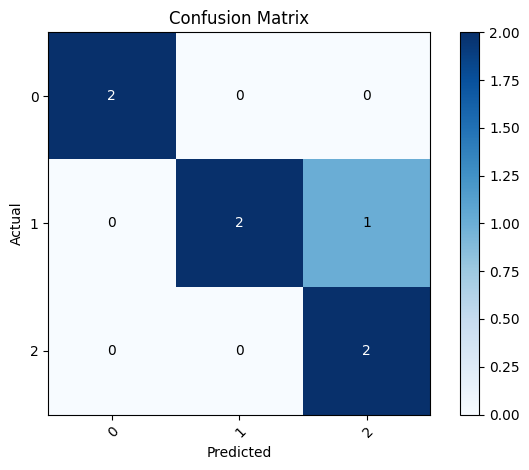

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    classes = [str(c) for c in classes]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

# ... (Your existing code for data preparation)

# Example usage
# Replace y_true and y_pred with your actual and predicted values
y_true = np.array([1, 0, 1, 2, 0, 1, 2])
y_pred = np.array([1, 0, 1, 2, 0, 2, 2])

# Replace classes with the unique classes in your target variable
classes = unique_labels(y_true, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix')
